<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:36px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Title</b></div>

<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Text text text</b></div>

<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Introduction</b></div>

<div style="text-align: justify;">Text text text
</div>

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Table of Contents</b></div>

<div style="background-color:aliceblue; padding:30px; font-size:15px;color:#034914">
    
<a id="TOC"></a>
    
* [Code setup](#code_setup)
* [Import libraries and load data](#import)
* [Data Preprocessing](#data_preprocessing)
* [Model Evaluation Functions](#model_evaluation)
* [The GLM benchmark model](#glm)
* [The Combined Actuarial Neural Network](#cann)
* [LocalGLMNet](#localglm)
* [TabNet](#tabnet)
* [Results evaluation](#results)
* [References](#ref)
* [Related Projects](#rel)

<a id="code_setup"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Code setup</b></div>

UPDATE

The python version used for this notebook is 3.10.x

We recommend to create a dedicated Conda environment for this notebook. See the example terminal commands:

Along with the python version, please install:

- Create a new conda environment named 'dl-env' with Python 3.10:
*conda create -n dl-env python=3.10*

- Activate the new environment:
*conda activate dl-env*

- Install the required packages:
*conda install pandas scikit-learn matplotlib numpy seaborn scipy*

- Install TensorFlow using pip:
*pip install tensorflow*

- Install PyTorch and torchvision for CPU only:
*conda install pytorch torchvision torchaudio cpuonly -c pytorch*

<a id="import"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Import libraries and load data</b></div>

In [20]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_poisson_deviance
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Nadam

import torch
from pytorch_tabnet.tab_model import TabNetRegressor

For simplicity and transparency, we use an open source dataset with a portfolio of car insurance policies and claims. The dataset can be loaded from the repository or it can be found on Kaggle (https://www.kaggle.com/datasets/floser/french-motor-claims-datasets-fremtpl2freq). This is a well-known and often used dataset for modelling. This provides transparency as results can be benchmarked to other work.

In [21]:
# Load the dataset (replace with your actual file path)
data = pd.read_csv('C:/Users/bart_/Documents/git_repo/DL_for_Actuaries/data/freMTPL2freq.csv')

# Inspect the dataset
data.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


In [22]:
data.shape

(678013, 12)

<a id="data_preprocessing"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Data Preprocessing</b></div>

The preprocessing is largely based on Richman & Wüthrich (2023), meaning that data in the tails will be right-censored. Furthermore, the Area feature is encoded to be treated as a continuous feature.

The dataset consists of a mix of numerical and categorical features. Many machine learning models cannot process categorical features in their raw format, so we need to One-Hot encode the categorical features. Furthermore, it is common the standardize numerical data before training. Both the standardization and onehot encoding are applied below in a preprocessing pipeline. 

Another important step is the creation of a train and test sample, a 90/10 split will be used.

In [23]:
# Some data preparation
exposure = data['Exposure']

# Right-censor the data to deal with low observations
data['VehAge'] = data['VehAge'].clip(upper=20)
data['DrivAge'] = data['DrivAge'].clip(upper=90)
data['BonusMalus'] = data['BonusMalus'].clip(upper=150)
data["ClaimNb"] = data["ClaimNb"].clip(upper=5)

# Encode Area as continuous
area_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6}
data['Area'] = data['Area'].map(area_mapping)

# Remove missing values
data = data.dropna()

# Preprocess the Dataset
numerical_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus','Area']
categorical_features = ['VehBrand', 'Region','VehGas']

y = data['ClaimNb']
X = data.drop(columns=['ClaimNb', 'Exposure', 'IDpol'], axis=1)

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Split the dataset including the exposure
X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(
    X, y, exposure, test_size=0.1, random_state=42
)

# Apply the preprocessing pipeline
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get categorical feature names from OneHotEncoder
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()

# Combine numerical and encoded categorical feature names
feature_names = numerical_features + cat_feature_names

In [24]:
data["ClaimFrequency"] = data["ClaimNb"]/data["Exposure"]
data["ClaimFrequency"] = data["ClaimFrequency"].clip(upper=10)

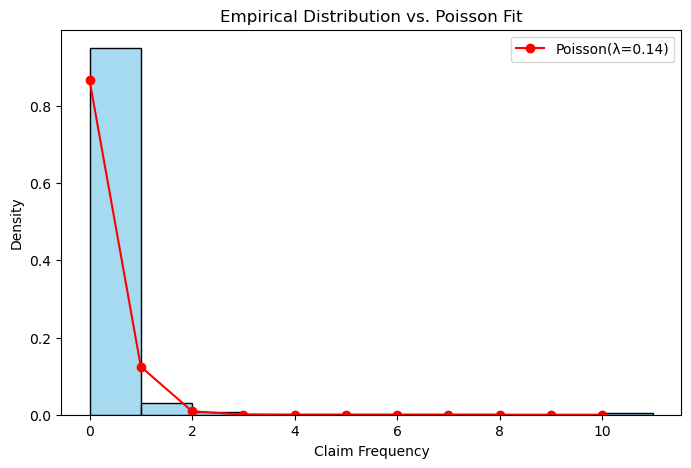

In [25]:
from scipy.stats import poisson

# Example data (replace with your df["claim_frequency"])
select = data["ClaimFrequency"]

lambda_hat = select.mean()

# Histogram of the data
plt.figure(figsize=(8, 5))
sns.histplot(
    select,
    stat="density",
    bins=range(int(select.min()), int(select.max()) + 2),  # ✅ cast to int
    color="skyblue",
    edgecolor="black"
)

# Poisson PMF (discrete values)
x_vals = np.arange(0, int(select.max()) + 1)
poisson_pmf = poisson.pmf(x_vals, mu=lambda_hat)

# Overlay Poisson distribution as red dots and line
plt.plot(x_vals, poisson_pmf, "o-", color="red", label=f"Poisson(λ={lambda_hat:.2f})")

# Labels, legend, and title
plt.xlabel("Claim Frequency")
plt.ylabel("Density")
plt.title("Empirical Distribution vs. Poisson Fit")
plt.legend()

plt.show()

<a id="model_evaluation"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Model Evaluation Functions</b></div>

In this section we will define functions that will evaluate the model performance. As evaluation metrics we chose RMSE, mean absolute error (MAE) and Poisson deviance as they are commonly used for model performance assessment. Furthermore, we define functions for graphical evaluation with quantile plots (showing actuals vs predictions) and double lift charts for model comparison. 

In [26]:
# Dictionary to store evaluation results
model_results = {}

# Function to calculate model performance metrics and store them in a dict
def evaluate_model(model_name, y_true, y_pred):
    rmse = float(root_mean_squared_error(y_true, y_pred))  # Convert to float
    mae = float(mean_absolute_error(y_true, y_pred))  # Convert to float
    poisson_dev = float(mean_poisson_deviance(y_true, y_pred))  # Convert to float

    # Store results in the dictionary
    model_results[model_name] = {
        "RMSE": rmse,
        "MAE": mae,
        "Poisson Deviance": poisson_dev
    }

    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, Poisson Deviance: {poisson_dev:.4f}")


In [27]:
def quantile_plot(model_name, y_true, y_pred, exposure, num_bins=10):
    import pandas as pd
    import matplotlib.pyplot as plt

    # Convert to rates
    actual_rate = y_true / exposure
    predicted_rate = y_pred / exposure

    # Create a DataFrame
    df = pd.DataFrame({
        'ActualRate': actual_rate,
        'PredictedRate': predicted_rate,
        'Exposure': exposure
    })

    # Create deciles based on predicted rate
    df['Decile'] = pd.qcut(df['PredictedRate'], q=num_bins, labels=False, duplicates='drop')

    # Calculate summaries per decile
    decile_summary = (
        df.groupby('Decile')
          .agg({
              'ActualRate': 'mean',
              'PredictedRate': 'mean',
              'Exposure': 'sum'
          })
          .reset_index()
    )

    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.plot(decile_summary['Decile'], decile_summary['ActualRate'], marker='o', label='Actual Rate', color="blue")
    ax1.plot(decile_summary['Decile'], decile_summary['PredictedRate'], marker='x', label='Predicted Rate', color="orange")
    ax1.set_xlabel('Decile (by predicted rate)')
    ax1.set_ylabel('Average Claim Rate')
    ax1.legend(loc="upper left")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.bar(decile_summary['Decile'], decile_summary['Exposure'], alpha=0.3, color="cornflowerblue", width=0.8, label="Total Exposure")
    ax2.set_ylabel("Total Exposure")
    ax2.legend(loc="upper right")

    plt.title(f"Calibration plot with exposure: {model_name}")
    plt.show()

<a id="model_evaluation"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>The GLM benchmark model</b></div>

As a first step and benchmark we will now fit a GLM. As we are predicting claim frequency (count) we will use a Poisson distribution. For this we employ a PoissonRegressor from Scikit learn's linear model library. The only parameter that is defined in the Poisson Regressor is 'alpha', which indicates the regularization strength (the extent to which L2 penalty terms are applied). For this simple implementation we will go with traditional, unpenalized GLMs (alpha=0).  

In [28]:
# Instantiate the Poisson regressor
glm = PoissonRegressor(alpha=0)
glm.fit(X_train, y_train, sample_weight=exposure_train)

PoissonRegressor(alpha=0)

Now the GLM is fitted, we can inspect the features and coefficients:

In [29]:
# Get the coefficients from the model
coefficients = glm.coef_

# Display
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False).drop(columns="Abs_Coefficient")
print(coef_df)

           Feature  Coefficient
3       BonusMalus     0.359343
28      Region_R53     0.241736
8     VehBrand_B12    -0.212266
2          DrivAge     0.193131
20      Region_R24     0.188820
1           VehAge    -0.178917
31      Region_R73    -0.164492
33      Region_R82     0.164018
35      Region_R91    -0.161306
24      Region_R41    -0.158095
14     VehBrand_B5     0.114863
21      Region_R25     0.111309
23      Region_R31    -0.101888
30      Region_R72    -0.094800
27      Region_R52     0.084595
19      Region_R23    -0.076946
34      Region_R83    -0.073472
4             Area     0.072509
32      Region_R74     0.054861
6     VehBrand_B10    -0.049805
39  VehGas_Regular    -0.044980
5      VehBrand_B1     0.044221
0         VehPower     0.043814
10    VehBrand_B14    -0.040050
9     VehBrand_B13     0.037687
7     VehBrand_B11     0.029530
11     VehBrand_B2     0.029042
26      Region_R43    -0.026685
15     VehBrand_B6    -0.023234
22      Region_R26    -0.018173
17      

For evaluation, we first need to make predictions on our test sample. When predictions on X_test are available, we can call the evaluation function and plot the double lift chart:

In [30]:
# Get GLM predictions
glm_preds_train = glm.predict(X_train)
glm_preds_test = glm.predict(X_test)

In [31]:
# Evaluate GLM
evaluate_model("GLM", y_test, glm_preds_test)

GLM - RMSE: 0.2343, MAE: 0.1103, Poisson Deviance: 0.3121


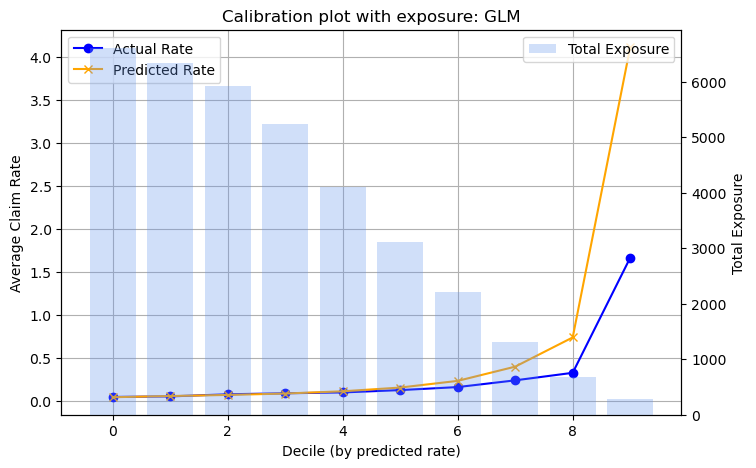

In [32]:
quantile_plot("GLM",y_test, glm_preds_test, exposure_test)